In [3]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

In [7]:
train_path = 'C:/Users/rekmani/Documents/dojo/train'
valid_path = 'C:/Users/rekmani/Documents/dojo/valid'
test_path = 'C:/Users/rekmani/Documents/dojo/test'

In [8]:
train_batches = ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224),classes=['dog','cat'],batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,target_size=(224,224),classes=['dog','cat'],batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224),classes=['dog','cat'],batch_size=10)

Found 800 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [9]:
def plots(ims,figsize=(12,6),rows=1,interp=False,titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose(0,2,3,1)
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims)%2 == 0 else len(ims)//rows+1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i],fontsize=16)
        plt.imshow(ims[i],interpolation=None if interp else 'none')

In [10]:
imgs,labels = next(train_batches)

C:\Users\rekmani\anaconda3\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


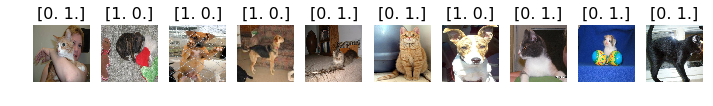

In [11]:
plots(imgs,titles=labels)

Building CNN

In [12]:
model = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)),
    Flatten(),
    Dense(2,activation='softmax'),
])

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.compile(Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
model.fit_generator(train_batches,steps_per_epoch = 80,validation_data=valid_batches,validation_steps=4,epochs=5,verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 19s - loss: 7.9210 - acc: 0.5075 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
 - 18s - loss: 7.8979 - acc: 0.5100 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/5
 - 18s - loss: 7.9180 - acc: 0.5088 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
 - 17s - loss: 8.0188 - acc: 0.5025 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/5
 - 18s - loss: 7.8576 - acc: 0.5125 - val_loss: 8.0590 - val_acc: 0.5000


Make predictions with a Keras CNN Image Classifier

In [15]:
test_imgs,test_labels =  next(test_batches)

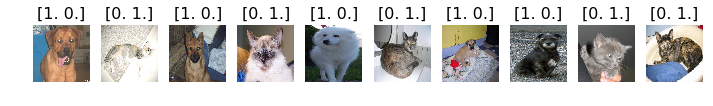

In [16]:
plots(test_imgs,titles=test_labels)

In [17]:
# convert 2 dimensional labels to one dimension
test_labels = test_labels[:,0]
test_labels

array([1., 0., 1., 0., 1., 0., 1., 1., 0., 0.], dtype=float32)

In [18]:
# get and print predictions
predictions = model.predict_generator(test_batches,steps=1,verbose=0)
predictions

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

Confusion Matrix

In [19]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
cm = confusion_matrix(test_labels,predictions[:,0])
cm

array([[0, 5],
       [1, 4]], dtype=int64)

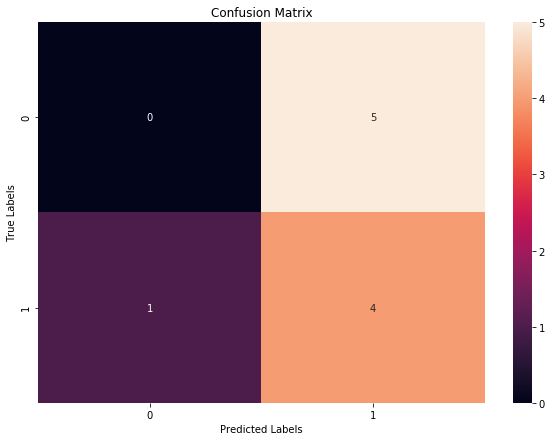

In [21]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
# Add title and axis names
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels');

Build a fine tuned VGG16 Model {2014 ImageNet winner}

In [22]:
vgg16_model = keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 396s 1us/step


In [23]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [24]:
type(vgg16_model)
# this is not a sequential model instead it comes from Keras functional API

keras.engine.training.Model

In [26]:
# copy the layers of the above model into a sequential model {except for the last one}
model = Sequential()
for i, layer in enumerate(vgg16_model.layers):
    if i < len(vgg16_model.layers)-1:
        model.add(layer)

In [27]:
type(model)

keras.engine.sequential.Sequential

In [28]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [29]:
# freeze the existing layers
for layer in model.layers:
    layer.trainable = False

In [30]:
model.add(Dense(2,activation='softmax'))

In [31]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [32]:
model.compile(Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [33]:
model.fit_generator(train_batches,steps_per_epoch = 80,validation_data=valid_batches,validation_steps=4,epochs=5,verbose=2)

Epoch 1/5
 - 312s - loss: 0.4514 - acc: 0.8112 - val_loss: 0.2316 - val_acc: 0.8750
Epoch 2/5
 - 411s - loss: 0.1479 - acc: 0.9425 - val_loss: 0.0816 - val_acc: 1.0000
Epoch 3/5
 - 379s - loss: 0.0947 - acc: 0.9650 - val_loss: 0.0669 - val_acc: 1.0000
Epoch 4/5
 - 302s - loss: 0.0754 - acc: 0.9700 - val_loss: 0.0504 - val_acc: 1.0000
Epoch 5/5
 - 328s - loss: 0.0495 - acc: 0.9862 - val_loss: 0.0226 - val_acc: 1.0000


Make predictions with a Keras CNN Image Classifier

In [34]:
test_imgs,test_labels =  next(test_batches)

C:\Users\rekmani\anaconda3\lib\site-packages\matplotlib\text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


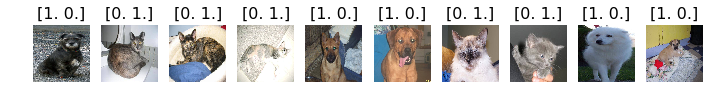

In [35]:
plots(test_imgs,titles=test_labels)

In [36]:
# convert 2 dimensional labels to one dimension
test_labels = test_labels[:,0]
test_labels

array([1., 0., 0., 0., 1., 1., 0., 0., 1., 1.], dtype=float32)

In [37]:
# get and print predictions
predictions = model.predict_generator(test_batches,steps=1,verbose=0)
predictions

array([[2.3260855e-03, 9.9767393e-01],
       [5.3110620e-05, 9.9994683e-01],
       [8.7128544e-01, 1.2871455e-01],
       [1.3772839e-01, 8.6227155e-01],
       [1.1584597e-04, 9.9988413e-01],
       [7.6368135e-01, 2.3631869e-01],
       [9.6856261e-04, 9.9903142e-01],
       [9.1426748e-01, 8.5732490e-02],
       [1.3741311e-01, 8.6258686e-01],
       [9.9875760e-01, 1.2423677e-03]], dtype=float32)

In [38]:
predictions_classes = predictions[:,0] > 0.5
predictions_classes

array([False, False,  True, False, False,  True, False,  True, False,
        True])

In [39]:
cm = confusion_matrix(test_labels,predictions_classes)
cm

array([[3, 2],
       [3, 2]], dtype=int64)

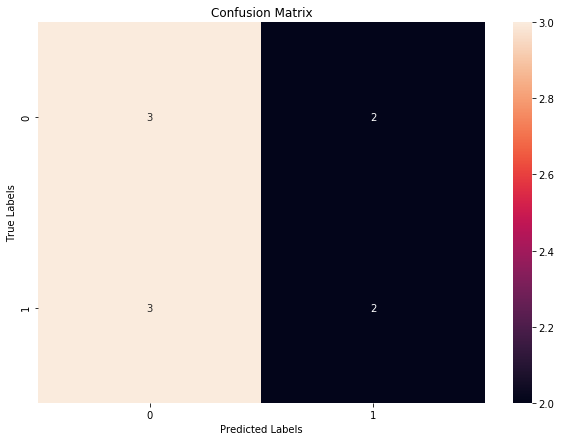

In [40]:
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
# Add title and axis names
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels');

In [41]:
# calculate the metrics on the test data
from sklearn.metrics import accuracy_score
score = accuracy_score(test_labels, predictions_classes)
score

0.5

[1. 0. 0. 1. 0. 0. 1. 0. 1. 1.]
[[9.1426748e-01 8.5732490e-02]
 [1.3741311e-01 8.6258686e-01]
 [1.1584597e-04 9.9988413e-01]
 [8.7128544e-01 1.2871455e-01]
 [9.6856261e-04 9.9903142e-01]
 [9.9875760e-01 1.2423671e-03]
 [2.3260855e-03 9.9767393e-01]
 [5.3110620e-05 9.9994683e-01]
 [7.6368129e-01 2.3631869e-01]
 [1.3772839e-01 8.6227167e-01]]
[ True False False  True False  True False False  True False]
[[4 1]
 [2 3]]
0.7


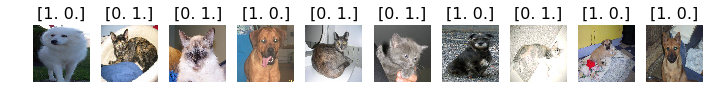

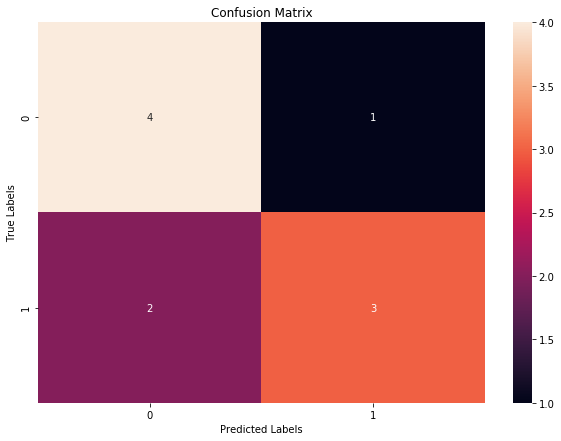

In [42]:
test_imgs,test_labels =  next(test_batches)
plots(test_imgs,titles=test_labels)

# convert 2 dimensional labels to one dimension
test_labels = test_labels[:,0]
print(test_labels)

# get and print predictions
predictions = model.predict_generator(test_batches,steps=1,verbose=0)
print(predictions)

predictions_classes = predictions[:,0] > 0.5
print(predictions_classes)
cm = confusion_matrix(test_labels,predictions_classes)
print(cm)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)
# Add title and axis names
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels');

# calculate the metrics on the test data
from sklearn.metrics import accuracy_score
score = accuracy_score(test_labels, predictions_classes)
print(score)